In [1]:
import matplotlib.pyplot as plt
import numpy as np
FILE_NAME = "result1.txt"

In [2]:
from random import random, randint, sample, choice

POPULATION_SIZE = 50
TOURNAMENT_SIZE = 3
MIN_POINTS = 3 # Minium number of points in multipoints crossover
MAX_POINTS = 10 # Maximum number of points in multipoints crossover
MUTATION_RATE = 0.015
ELITE_SIZE = 1
GENE_LENGTH = 67

# Dictionaries to convert genotype to phenotype
LEARNING_RATE_DICT = {
    0: 1 * 10 ** (-5), 1: 5 * 10 ** (-5),
    2: 1 * 10 ** (-4), 3: 5 * 10 ** (-4),
    4: 1 * 10 ** (-3), 5: 5 * 10 ** (-3),
    6: 1 * 10 ** (-2), 7: 5 * 10 ** (-2),
}

DENSE_TYPE_DICT = {
    0: "recurrent", 1: "feed-forward"
}

REGULARIZATION_DICT = {
    0: "l1", 1: "l2", 2: "l1l2", 3: None
}

ACTIVATION_DICT = {
    0: "relu",
    1: "linear"
}

In [3]:
def count_same_element(array1, array2):
    return [array1[i] == array2[i] for i in range(len(array1))].count(True)

def get_similarity(individual1, individual2):
    nc1 = individual1.get_convol_layers_num()
    nc2 = individual2.get_convol_layers_num()
    nd1 = individual1.get_dense_layers_num()
    nd2 = individual2.get_dense_layers_num()
    if nc1 == nc2 and nd1 == nd2:
        properies_num = nc1 * 4 + nd1 * 5 + 2
        same_count = 0

        f1, f2 = individual1.get_optimizer(), individual2.get_optimizer()
        if f1 == f2:
            same_count += 1
        n1 = individual1.get_learning_rate()
        n2 = individual1.get_learning_rate()
        if n1 == n2:
            same_count += 1

        ck1 = individual1.get_kernels_num(nc1)
        ck2 = individual2.get_kernels_num(nc2)
        same_count += count_same_element(ck1, ck2)
        cs1 = individual1.get_kernel_sizes(nc1)
        cs2 = individual2.get_kernel_sizes(nc2)
        same_count += count_same_element(cs1, cs2)
        cp1 = individual1.get_pooling(nc1)
        cp2 = individual2.get_pooling(nc2)
        same_count += count_same_element(cp1, cp2)
        ca1 = individual1.get_convol_activation(nc1)
        ca2 = individual2.get_convol_activation(nc2)
        same_count += count_same_element(ca1, ca2)

        dt1 = individual1.get_dense_type(nd1)
        dt2 = individual2.get_dense_type(nd2)
        same_count += count_same_element(dt1, dt2)
        dn1 = individual1.get_neurons_num(nd1)
        dn2 = individual2.get_neurons_num(nd2)
        same_count += count_same_element(dn1, dn2)
        da1 = individual1.get_dense_activation(nd1)
        da2 = individual2.get_dense_activation(nd2)
        same_count += count_same_element(da1, da2)
        dr1 = individual1.get_regularization(nd1)
        dr2 = individual2.get_regularization(nd2)
        same_count += count_same_element(dr1, dr2)
        dd1 = individual1.get_dropout(nd1)
        dd2 = individual2.get_dropout(nd2)
        same_count += count_same_element(dd1, dd2)
        return same_count / properies_num
    else:
        return 0

def binary_to_decimal(bits):
    return int("".join(map(str, bits)), 2)

In [4]:
class Individual(object):
    def __init__(self, *args):
        if not args: # New initialization from start
            self.gene = [randint(0, 1) for i in range(GENE_LENGTH)]
        elif len(args) == 1:
            self.gene = args[0]
        else:
            self.gene = args[0]
            self.fitness = args[1]
            self.adjusted_fitness = args[2]

    def mutate(self):
        for i in range(GENE_LENGTH):
            odd = random() <= 0.015
            self.gene[i] = int(not self.gene[i]) if odd else self.gene[i]

    def get_batch_size(self):
        return [25, 50, 100, 15][binary_to_decimal(self.gene[:2])]

    def get_convol_layers_num(self):
        return 1 + binary_to_decimal(self.gene[2:4])

    def get_kernels_num(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[4 + i * 10: 4 + i * 10 + 3]
            result.append(2 ** (binary_to_decimal(binary) + 1))
        return result

    def get_kernel_sizes(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[7 + i * 10: 7 + i * 10 + 3]
            result.append(2 + binary_to_decimal(binary))
        return result

    def get_pooling(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[10 + i * 10: 10 + i * 10 + 3]
            result.append(1 + binary_to_decimal(binary))
        return result

    def get_convol_activation(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[13 + i * 10: 13 + i * 10 + 1]
            result.append(ACTIVATION_DICT[binary_to_decimal(binary)])
        return result

    def get_dense_layers_num(self):
        return 1 + binary_to_decimal([self.gene[44]])

    def get_dense_type(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[45 + i * 8: 45 + i * 8 + 1]
            result.append(DENSE_TYPE_DICT[binary_to_decimal(binary)])
        return result

    def get_neurons_num(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[46 + i * 8: 46 + i * 8 + 3]
            result.append(2 ** (binary_to_decimal(binary) + 3))
        return result

    def get_dense_activation(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[49 + i * 8: 49 + i * 8 + 1]
            result.append(ACTIVATION_DICT[binary_to_decimal(binary)])
        return result

    def get_regularization(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[50 + i * 8: 50 + i * 8 + 2]
            result.append(binary_to_decimal(binary))
        return result

    def get_dropout(self, layers_num):
        result = []
        for i in range(layers_num):
            binary = self.gene[52 + i * 8: 52 + i * 8 + 1]
            result.append(binary_to_decimal(binary) / 2)
        return result

    def get_optimizer(self):
        binary = self.gene[61: 64]
        return binary_to_decimal(binary)

    def get_learning_rate(self):
        binary = self.gene[64: 67]
        return LEARNING_RATE_DICT[binary_to_decimal(binary)]

    def get_components(self):
        dct = {}

        dct["b"] = self.get_batch_size()

        # Convolutional layers
        dct["nc"] = self.get_convol_layers_num()
        dct["ck"] = self.get_kernels_num(dct["nc"])
        dct["cs"] = self.get_kernel_sizes(dct["nc"])
        dct["cp"] = self.get_pooling(dct["nc"])
        dct["ca"] = self.get_convol_activation(dct["nc"])

        # Dense layers
        dct["nd"] = self.get_dense_layers_num()
        dct["dt"] = self.get_dense_type(dct["nd"])
        dct["dn"] = self.get_neurons_num(dct["nd"])
        dct["da"] = self.get_dense_activation(dct["nd"])
        dct["dd"] = self.get_dropout(dct["nd"])
        dct["dr"] = self.get_regularization(dct["nd"])

        # Learning parameters
        dct["n"] = self.get_learning_rate()
        dct["f"] = self.get_optimizer()

        return dct

    def get_str_model(self):
        b = self.get_batch_size()

        # Convolutional layers
        nc = self.get_convol_layers_num()
        ck = self.get_kernels_num(nc)
        cs = self.get_kernel_sizes(nc)
        cp = self.get_pooling(nc)
        ca = self.get_convol_activation(nc)

        # Dense layers
        nd = self.get_dense_layers_num()
        dt = self.get_dense_type(nd)
        dn = self.get_neurons_num(nd)
        da = self.get_dense_activation(nd)
        dd = self.get_dropout(nd)
        dr = self.get_regularization(nd)

        # Learning parameters
        n = self.get_learning_rate()
        f = self.get_optimizer()

        result = str(b) + "-" + str(nc) + "-"
        result += "-".join(list(map(str, ck))) + "-"
        result += "-".join(list(map(str, cs))) + "-"
        result += "-".join(list(map(str, cp))) + "-"
        result += "-".join(list(map(str, ca))) + "-"
        result += str(nd) + "-"
        result += "-".join(list(map(str, dt))) + "-"
        result += "-".join(list(map(str, dn))) + "-"
        result += "-".join(list(map(str, da))) + "-"
        result += "-".join(list(map(str, dd))) + "-"
        result += "-".join(list(map(str, dr))) + "-"
        result += str(n) + "-" + str(f)

        return result 

    def to_string(self):
        return "".join(map(str, self.gene))

dict_keys(['<bound method Individual.get_convol_layers_num of <__main__.Individual object at 0x7f357b023a00>>-<bound method Individual.get_dense_layers_num of <__main__.Individual object at 0x7f357b023a00>>', '<bound method Individual.get_convol_layers_num of <__main__.Individual object at 0x7f357992f490>>-<bound method Individual.get_dense_layers_num of <__main__.Individual object at 0x7f357992f490>>', '<bound method Individual.get_convol_layers_num of <__main__.Individual object at 0x7f35799af3a0>>-<bound method Individual.get_dense_layers_num of <__main__.Individual object at 0x7f35799af3a0>>', '<bound method Individual.get_convol_layers_num of <__main__.Individual object at 0x7f35799af640>>-<bound method Individual.get_dense_layers_num of <__main__.Individual object at 0x7f35799af640>>', '<bound method Individual.get_convol_layers_num of <__main__.Individual object at 0x7f35799af8e0>>-<bound method Individual.get_dense_layers_num of <__main__.Individual object at 0x7f35799af8e0>>',

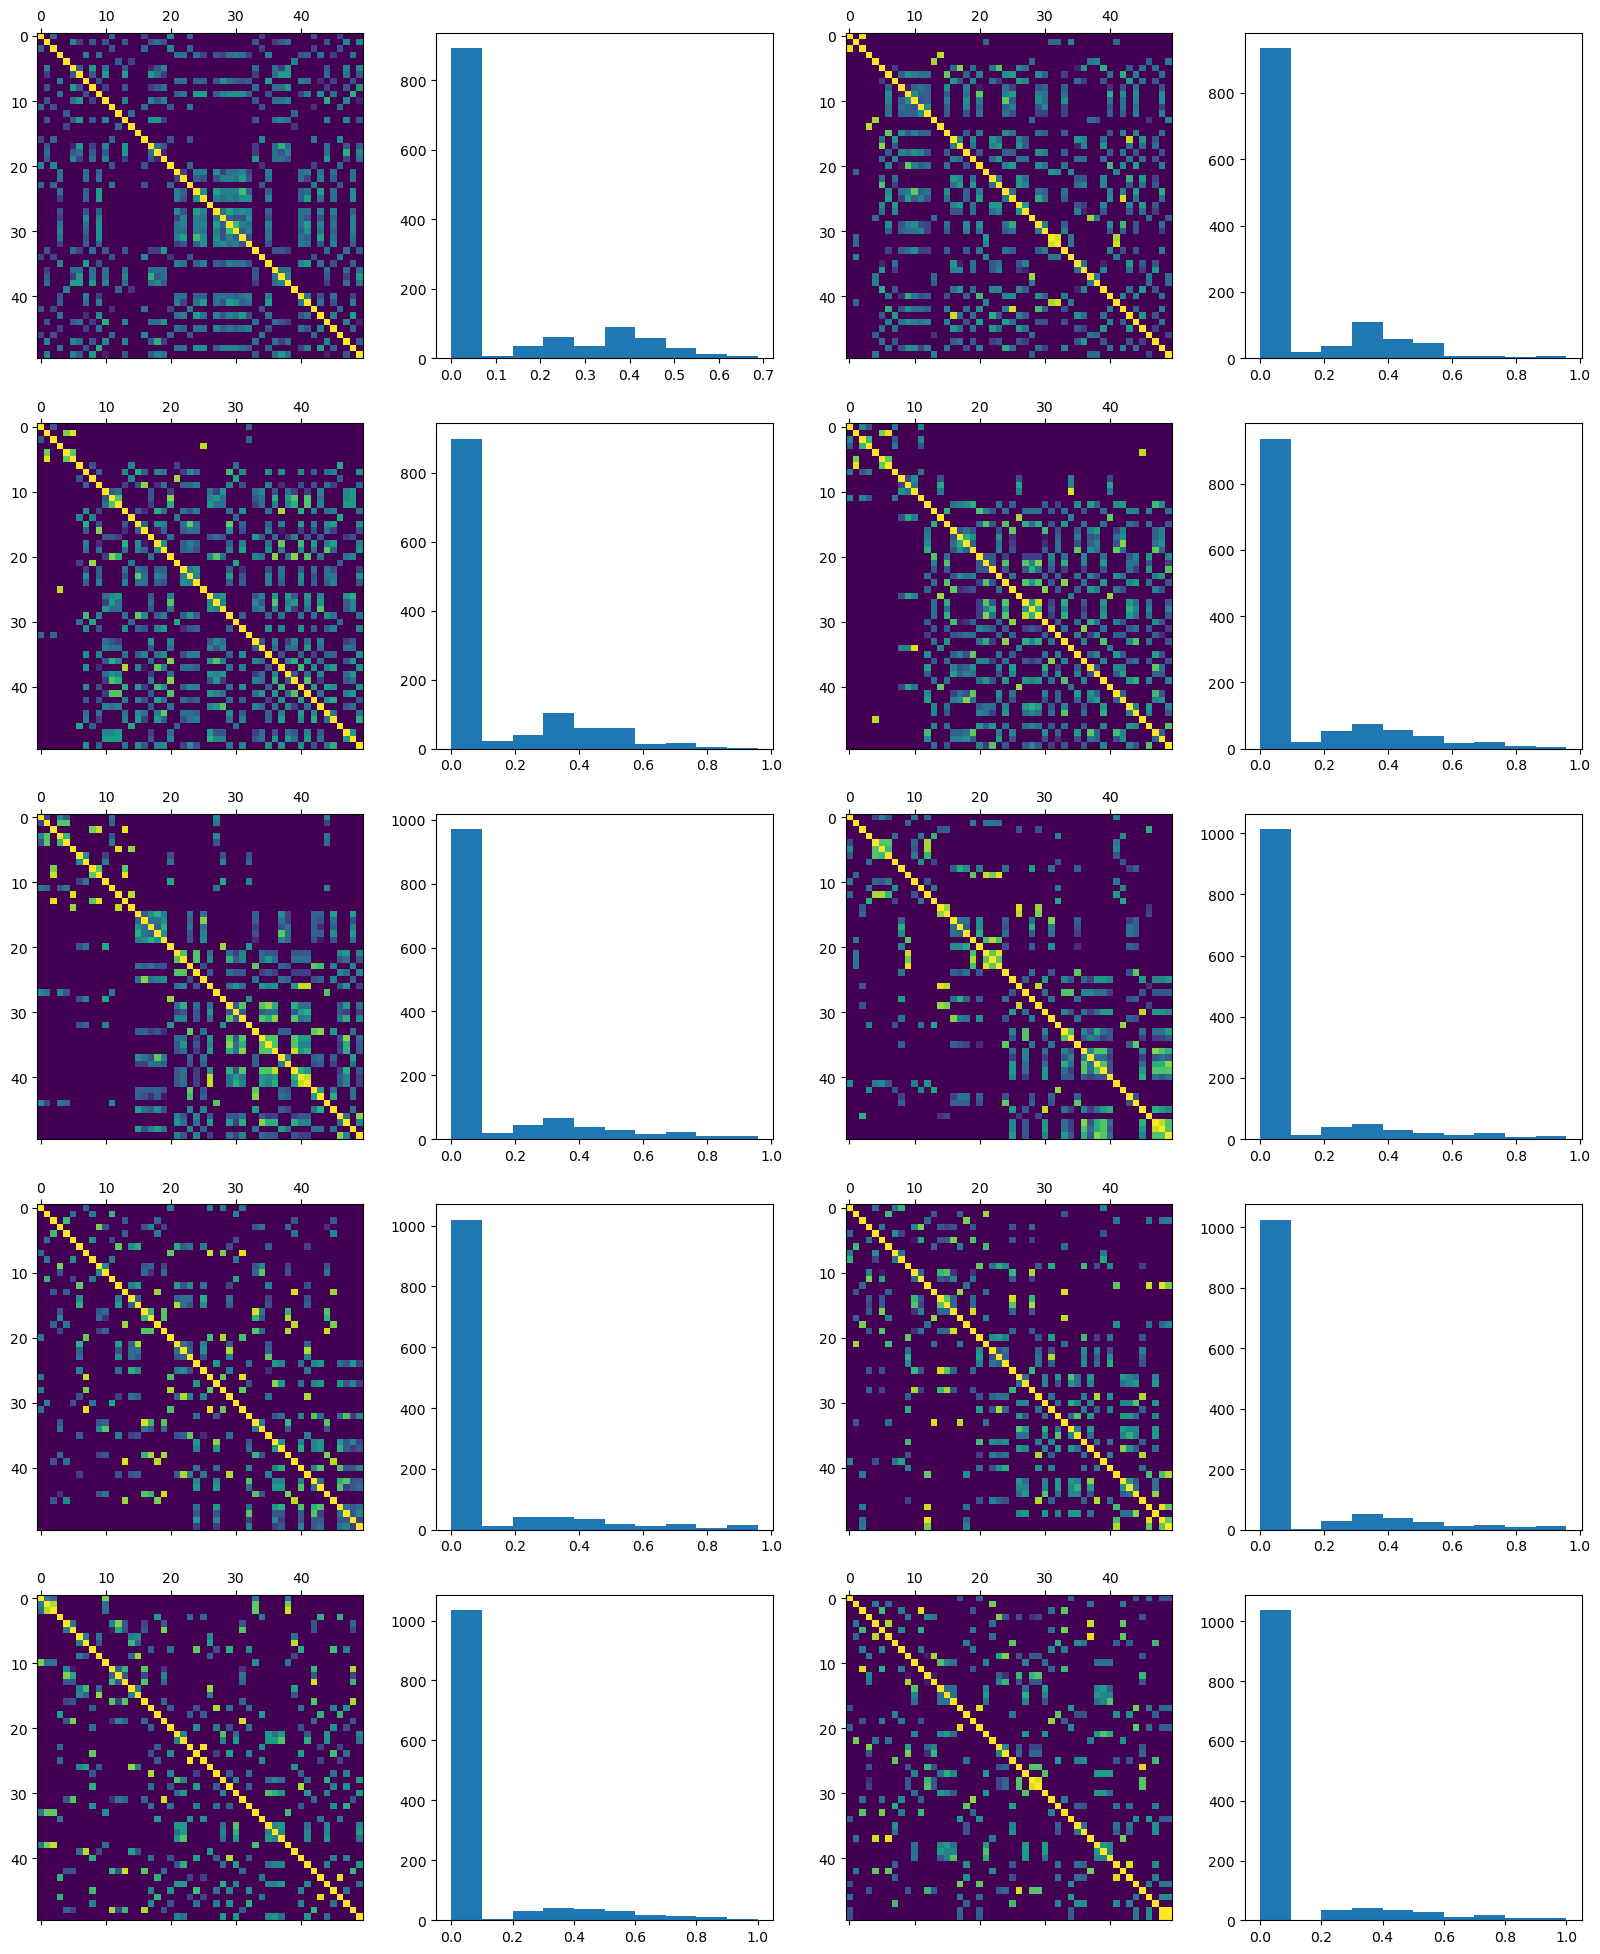

In [12]:
with open(FILE_NAME, "r") as f:
    data = f.readlines()
fig, ax = plt.subplots(figsize=(20, 25), dpi=100)
for k in range(10):
    group_dct, count_arr = {}, []
    ind = data.index("Generation " + str(k) + "\n")
    for j in range(1, 51):
        items = data[ind + j].strip().split()
        gene, fitness, adjusted_fitness = items[0], float(items[1]), float(items[2])
        individual = Individual(gene, fitness, adjusted_fitness)
        n_C, n_D = individual.get_convol_layers_num(), individual.get_dense_layers_num()
        try:
            group_dct[str(n_C) + "-" + str(n_D)].append(individual)
            for i in range(len(count_arr)):
                if count_arr[i][0] == str(n_C) + "-" + str(n_D):
                    count_arr[i][1] += 1
        except KeyError:
            group_dct[str(n_C) + "-" + str(n_D)] = [individual]
            count_arr.append([str(n_C) + "-" + str(n_D), 1])
    print(group_dct.keys())
    count_arr.sort(key = lambda x: x[1], reverse=True)
    population = []
    for item in count_arr:
        for ind in group_dct[item[0]]:
            population.append(ind)
    matrix = [[1 for i in range(POPULATION_SIZE)] for j in range(POPULATION_SIZE)]
    for i in range(POPULATION_SIZE - 1):
        for j in range(i + 1, POPULATION_SIZE):
            sim = get_similarity(population[i], population[j])
            matrix[i][j] = matrix[j][i] = sim
    mat = np.array(matrix)
    plt.subplot(5, 4, 2 * k + 1)
    count = []
    for i in range(49):
        for j in range(i + 1, 50):
            count.append(mat[i][j])
    plt.matshow(mat, fignum=False)
    plt.subplot(5, 4, 2 * k + 2)
    plt.hist(np.array(count), bins=10)
plt.show()